In [ ]:
# Amason reviews Classifaction & NLP analysis
# Rawan Al-Ahmadi & Nisreen Alsayegh

In [72]:
import os
import json
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from nltk.corpus import stopwords

# EDA:

In [442]:
### load the meta data
df =pd.read_json('Luxury_Beauty_5.json.gz',lines=True)
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1        5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2        5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

   unixReviewTime  vote image  
0      1515110400   NaN   NaN  
1      1491350400   NaN   NaN  
2      1490572800   NaN   NaN  
3      1489968000   NaN   NaN  
4      1488240000   NaN   NaN

In [446]:
# While most reviewers leave a 5 star review, there are also a good portion leaving 1 star reviews
df.reviewText.value_counts(normalize=True)

I was looking for a relatively inexpensive soap for ever day shaves. I like to save my artisan stock for special occasions and I am not made of money ya know. As a mass produced soap it's actually really nice. It loads well, though I will say it loads better on stiffer brushes than softer ones. The scent is nice and has some staying power. The slickness is about average I would say and it provides decent cushion. Is this the best soap in the world? Nope. Is this soap a decent proformer at a great price point? Absolutely. One of the advantages of this soap over the cream in a tube is that it has a better post shave. Not sure why but it is definitely more moisturizing and has a better finish than the tube creams from Proraso. This is their sensitive skin formula (and I have some sensitive skin.) Let me just say a preshave is a must. I use an oil but you could use theirs as well. A good preshave and prep will make this soap preform better. without a preshave treatment this soap is still t

In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34278 entries, 0 to 34277
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         34278 non-null  int64  
 1   verified        34278 non-null  bool   
 2   reviewTime      34278 non-null  object 
 3   reviewerID      34278 non-null  object 
 4   asin            34278 non-null  object 
 5   style           16841 non-null  object 
 6   reviewerName    34278 non-null  object 
 7   reviewText      34265 non-null  object 
 8   summary         34263 non-null  object 
 9   unixReviewTime  34278 non-null  int64  
 10  vote            6532 non-null   float64
 11  image           617 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 2.9+ MB


In [444]:
df.describe()

overall  unixReviewTime         vote
count  34278.00000    3.427800e+04  6532.000000
mean       4.28616    1.445171e+09     7.315677
std        1.03736    4.962381e+07    21.295736
min        1.00000    1.127174e+09     2.000000
25%        4.00000    1.411430e+09     2.000000
50%        5.00000    1.448410e+09     3.000000
75%        5.00000    1.484093e+09     6.000000
max        5.00000    1.537747e+09   686.000000

In [4]:
df.shape

(34278, 12)

In [448]:
df.overall.unique()

array([5, 4, 3, 1, 2], dtype=int64)

## Handling the time column:

In [449]:
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df["unixReviewTime"] = df["unixReviewTime"].apply(condition)


In [454]:

df[["month", "day", "year"]] = df["unixReviewTime"].str.split("-", expand = True)
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1        5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2        5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

  unixReviewTime  vote image month day  year  
0     01-05-2018   NaN   NaN    01  05  2018  
1     04-05-2017   NaN   NaN    04  05  2017  
2     03-27-2017   NaN   NaN    03  27  2017  
3     03-20-2017   NaN   NaN    03  20  2017  
4     02-28-2017   NaN   NaN    02  28  2017

### Number of reviews across all months:

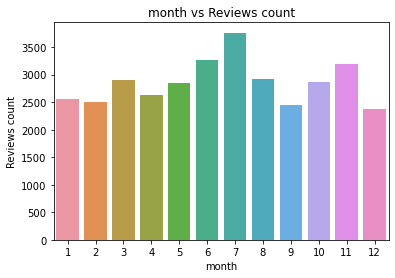

In [451]:
#Creating a dataframe
import seaborn as sns
import matplotlib.pyplot as plt 
month=pd.DataFrame(df.groupby('month')['reviewText'].count()).reset_index()
month['month']=month['month'].astype('int64')
month.sort_values(by=['month'])

#Plotting the graph
sns.barplot(x="month", y="reviewText", data=month)
plt.title('month vs Reviews count')
plt.xlabel('month')
plt.ylabel('Reviews count')
plt.show()

### Number of reviews across years:

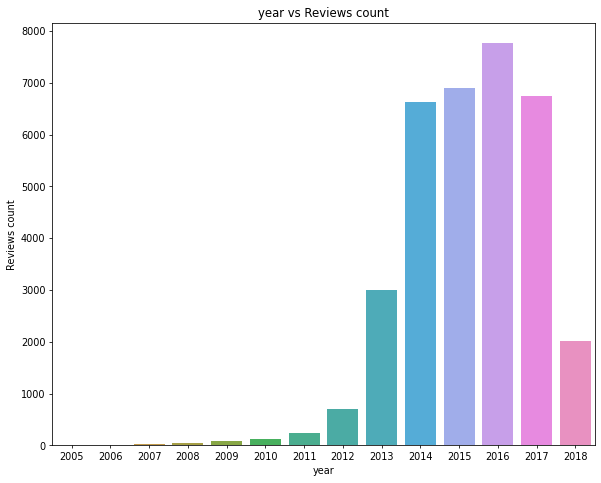

In [452]:
#Creating a dataframe
year=pd.DataFrame(df.groupby('year')['reviewText'].count()).reset_index()
year['year']=year['year'].astype('int64')
year.sort_values(by=['year'])

#Plotting the graph
plt.subplots(figsize=(10,8), dpi=70)
sns.barplot(x="year", y="reviewText", data=year)
plt.title('year vs Reviews count')
plt.xlabel('year')
plt.ylabel('Reviews count')
plt.show()


In [455]:
df['reviewText']=df['reviewText'].astype(str) # turning the text column to string type
df

overall  verified   reviewTime      reviewerID        asin  \
0            5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1            5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2            5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3            5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4            5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
...        ...       ...          ...             ...         ...   
34273        4     False   09 3, 2017  A2CF66KIQ3RKX3  B01GOZ61O8   
34274        4     False   09 3, 2017  A1LKOIZXPQ9VG0  B01GOZ61O8   
34275        1      True  08 25, 2017   AV2RWORXTFRJU  B01H353HUY   
34276        5     False   07 8, 2017  A22S7D0LP8GRDH  B01H353HUY   
34277        5      True   07 9, 2018   AAF5D1LTFGB7L  B01HGSJPMW   

                       style           reviewerName  \
0      {'Size:': ' 0.9 oz.'}                     DB   
1      {'Size:': ' 3.5 oz.'}                  Ajaey   
2        {'Size:': ' 250 g'}               D. Jones   
3      {'Size:': ' 3.5 oz.'}        Amazon Customer   
4      {'Size:': ' 0.9 oz.'}               D. Jones   
...                      ...                    ...   
34273                    NaN           Vivian Deliz   
34274                    NaN               Elisa 20   
34275                    NaN            Gapeachmama   
34276                    NaN  Jacob and Kiki Hantla   
34277                    NaN          Libby Johnson   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
34273  I like to use moisturizers and sunscreens that...   
34274  I wouldn't be able to afford this if not asked...   
34275                                        Did nothing   
34276  I love the Oribe bright blonde radiance spray....   
34277                 I love all of the Elemis products.   

                                                 summary unixReviewTime  vote  \
0                                    Beautiful Fragrance     01-05-2018   NaN   
1                                  wonderful hand lotion     04-05-2017   NaN   
2                                 Best hand cream around     03-27-2017   NaN   
3                                             Five Stars     03-20-2017   NaN   
4                                     Great hand lotion!     02-28-2017   NaN   
...                                                  ...            ...   ...   
34273         Works great as a moisturizer and sunscreen     09-03-2017   NaN   
34274  Nice skin care product and sunscreen if you do...     09-03-2017   NaN   
34275                                           One Star     08-25-2017   NaN   
34276                                     No more brass!     07-08-2017   NaN   
34277                                         Five Stars     07-09-2018   NaN   

      image month day  year  
0       NaN    01  05  2018  
1       NaN    04  05  2017  
2       NaN    03  27  2017  
3       NaN    03  20  2017  
4       NaN    02  28  2017  
...     ...   ...  ..   ...  
34273   NaN    09  03  2017  
34274   NaN    09  03  2017  
34275   NaN    08  25  2017  
34276   NaN    07  08  2017  
34277   NaN    07  09  2018  

[34278 rows x 15 columns]

# Cleaning the reviews to prepare for NLP analysis:

In [7]:
import re
def clean_review(text):
    cleaned_text = []
    for review in text:
        cleaned_words = []
        for word in review.split(' '):
            word = re.sub('&amp;', '', word)
            word = re.sub('_', '', word)
            if(not word.startswith("http")):
                word=re.sub(r"-"," ",word)
                word=re.sub(r"/"," ",word)
            word=re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)","",word)
            word=word.lower()
            word = re.sub(r"\b(?:a*(?:ha+)+h?|(?:l+o+)+l+)\b", '', word)
            cleaned_words.append(word)
        cleaned_text.append(' '.join(cleaned_words))  
    return cleaned_text

In [8]:
df['Clean_reviewText']=clean_review(df['reviewText'])
df

overall  verified   reviewTime      reviewerID        asin  \
0            5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1            5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2            5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3            5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4            5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
...        ...       ...          ...             ...         ...   
34273        4     False   09 3, 2017  A2CF66KIQ3RKX3  B01GOZ61O8   
34274        4     False   09 3, 2017  A1LKOIZXPQ9VG0  B01GOZ61O8   
34275        1      True  08 25, 2017   AV2RWORXTFRJU  B01H353HUY   
34276        5     False   07 8, 2017  A22S7D0LP8GRDH  B01H353HUY   
34277        5      True   07 9, 2018   AAF5D1LTFGB7L  B01HGSJPMW   

                       style           reviewerName  \
0      {'Size:': ' 0.9 oz.'}                     DB   
1      {'Size:': ' 3.5 oz.'}                  Ajaey   
2        {'Size:': ' 250 g'}               D. Jones   
3      {'Size:': ' 3.5 oz.'}        Amazon Customer   
4      {'Size:': ' 0.9 oz.'}               D. Jones   
...                      ...                    ...   
34273                    NaN           Vivian Deliz   
34274                    NaN               Elisa 20   
34275                    NaN            Gapeachmama   
34276                    NaN  Jacob and Kiki Hantla   
34277                    NaN          Libby Johnson   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
34273  I like to use moisturizers and sunscreens that...   
34274  I wouldn't be able to afford this if not asked...   
34275                                        Did nothing   
34276  I love the Oribe bright blonde radiance spray....   
34277                 I love all of the Elemis products.   

                                                 summary  unixReviewTime  \
0                                    Beautiful Fragrance      1515110400   
1                                  wonderful hand lotion      1491350400   
2                                 Best hand cream around      1490572800   
3                                             Five Stars      1489968000   
4                                     Great hand lotion!      1488240000   
...                                                  ...             ...   
34273         Works great as a moisturizer and sunscreen      1504396800   
34274  Nice skin care product and sunscreen if you do...      1504396800   
34275                                           One Star      1503619200   
34276                                     No more brass!      1499472000   
34277                                         Five Stars      1531094400   

       vote image                                   Clean_reviewText  
0       NaN   NaN  this handcream has a beautiful fragrance it do...  
1       NaN   NaN  wonderful hand lotion for seriously dry skin s...  
2       NaN   NaN  best hand cream around  silky thick soaks in a...  
3       NaN   NaN                                             thanks  
4       NaN   NaN  great hand lotion  soaks right in and leaves s...  
...     ...   ...                                                ...  
34273   NaN   NaN  i like to use moisturizers and sunscreens that...  
34274   NaN   NaN  i wouldnt be able to afford this if not asked ...  
34275   NaN   NaN                                        did nothing  
34276   NaN   NaN  i love the oribe bright blonde radiance spray ...  
34277   NaN   NaN                  i love all of the elemis products  

[34278 rows x 13 columns]

In [456]:
# spell Checker
from spellchecker import SpellChecker
def spelling_check(reviews):
    x=1
    new_reviews=[]
    for review in reviews:
        print(str(x)+" - ", end="")
        x=x+1
        review=re.sub(r'(.)\1{2,}', r'\1', review)
        new_review=[]
        splitted_review = review.split()
        spell = SpellChecker()
        for word in splitted_review:
            new_review.append(spell.correction(word))
        new_reviews.append(' '.join(new_review))
    return new_reviews

In [457]:
# df['Clean_reviewText']=spelling_check(df['Clean_reviewText'])
df

overall  verified   reviewTime      reviewerID        asin  \
0            5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1            5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2            5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3            5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4            5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
...        ...       ...          ...             ...         ...   
34273        4     False   09 3, 2017  A2CF66KIQ3RKX3  B01GOZ61O8   
34274        4     False   09 3, 2017  A1LKOIZXPQ9VG0  B01GOZ61O8   
34275        1      True  08 25, 2017   AV2RWORXTFRJU  B01H353HUY   
34276        5     False   07 8, 2017  A22S7D0LP8GRDH  B01H353HUY   
34277        5      True   07 9, 2018   AAF5D1LTFGB7L  B01HGSJPMW   

                       style           reviewerName  \
0      {'Size:': ' 0.9 oz.'}                     DB   
1      {'Size:': ' 3.5 oz.'}                  Ajaey   
2        {'Size:': ' 250 g'}               D. Jones   
3      {'Size:': ' 3.5 oz.'}        Amazon Customer   
4      {'Size:': ' 0.9 oz.'}               D. Jones   
...                      ...                    ...   
34273                    NaN           Vivian Deliz   
34274                    NaN               Elisa 20   
34275                    NaN            Gapeachmama   
34276                    NaN  Jacob and Kiki Hantla   
34277                    NaN          Libby Johnson   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
34273  I like to use moisturizers and sunscreens that...   
34274  I wouldn't be able to afford this if not asked...   
34275                                        Did nothing   
34276  I love the Oribe bright blonde radiance spray....   
34277                 I love all of the Elemis products.   

                                                 summary unixReviewTime  vote  \
0                                    Beautiful Fragrance     01-05-2018   NaN   
1                                  wonderful hand lotion     04-05-2017   NaN   
2                                 Best hand cream around     03-27-2017   NaN   
3                                             Five Stars     03-20-2017   NaN   
4                                     Great hand lotion!     02-28-2017   NaN   
...                                                  ...            ...   ...   
34273         Works great as a moisturizer and sunscreen     09-03-2017   NaN   
34274  Nice skin care product and sunscreen if you do...     09-03-2017   NaN   
34275                                           One Star     08-25-2017   NaN   
34276                                     No more brass!     07-08-2017   NaN   
34277                                         Five Stars     07-09-2018   NaN   

      image month day  year  
0       NaN    01  05  2018  
1       NaN    04  05  2017  
2       NaN    03  27  2017  
3       NaN    03  20  2017  
4       NaN    02  28  2017  
...     ...   ...  ..   ...  
34273   NaN    09  03  2017  
34274   NaN    09  03  2017  
34275   NaN    08  25  2017  
34276   NaN    07  08  2017  
34277   NaN    07  09  2018  

[34278 rows x 15 columns]

In [13]:
# lemmatize text
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatize_words(reviews, lemmatizer):
    cleaned_text=[]
    for review in reviews:
        cleaned_words=[]
        for word in review.split(' '):
            lem_word = lemmatizer.lemmatize(word)
            lem_word = re.sub(r"\b[a-zA-Z]\b", '', lem_word)
            cleaned_words.append(lem_word)
        cleaned_text.append(' '.join(cleaned_words))
    cleaned_text2 = []
    for post in cleaned_text:
        pattern = re.compile(r'\s+') 
        cleaned_text3 = re.sub(pattern, ' ', post).strip()
        cleaned_text2.append(''.join(cleaned_text3)) 
    return cleaned_text2

In [124]:
wordnet_lemmatizer = WordNetLemmatizer()
df['Clean_reviewText']=lemmatize_words(df['Clean_reviewText'],lemmatizer=wordnet_lemmatizer)

In [125]:
df.head(10)

overall  verified   reviewTime      reviewerID        asin  \
0        5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1        5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2        5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
5        5      True  02 25, 2017  A1606LA683WZZU  B00004U9V2   
6        5      True  02 25, 2017  A1606LA683WZZU  B00004U9V2   
7        5      True  01 30, 2017  A1606LA683WZZU  B00004U9V2   
8        4     False  01 24, 2017  A1YY53NQXFKMRN  B00004U9V2   
9        5      True   12 1, 2016  A3R0NQ9E53JHYQ  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   
5    {'Size:': ' 250 g'}              Amr   
6  {'Size:': ' 3.5 oz.'}              Amr   
7  {'Size:': ' 0.9 oz.'}              Amr   
8  {'Size:': ' 3.5 oz.'}           Trixie   
9    {'Size:': ' 250 g'}         T. Hooth   

                                          reviewText  \
0  This handcream has a beautiful fragrance. It d...   
1  wonderful hand lotion, for seriously dry skin,...   
2  Best hand cream around.  Silky, thick, soaks i...   
3                                           Thanks!!   
4  Great hand lotion.  Soaks right in and leaves ...   
5  Great product. Doesn't leave you hands feeling...   
6  Great product. Doesn't leave you hands feeling...   
7                Just as described. Arrived on time.   
8        Nice lightweight hand cream for the summer.   
9                              Best hand cream ever.   

                        summary  unixReviewTime  vote image  \
0           Beautiful Fragrance      1515110400   NaN   NaN   
1         wonderful hand lotion      1491350400   NaN   NaN   
2        Best hand cream around      1490572800   NaN   NaN   
3                    Five Stars      1489968000   NaN   NaN   
4            Great hand lotion!      1488240000   NaN   NaN   
5                    Five Stars      1487980800   NaN   NaN   
6                    Five Stars      1487980800   NaN   NaN   
7                    Five Stars      1485734400   NaN   NaN   
8  Smells good, absorbs quickly      1485216000   NaN   NaN   
9                    Five Stars      1480550400   NaN   NaN   

                                    Clean_reviewText  
0  this handcream ha beautiful fragrance it doesn...  
1  wonderful hand lotion for seriously dry skin s...  
2  best hand cream around silky thick soak in all...  
3                                             thanks  
4  great hand lotion soak right in and leaf skin ...  
5  great product doesnt leave you hand feeling gr...  
6  great product doesnt leave you hand feeling gr...  
7                     just described arrived on time  
8         nice lightweight hand cream for the summer  
9                               best hand cream ever

# pickling the datafame after the cleaninig , spell checher, and the lemmatiztion:

In [272]:
import pandas as pd
import pickle
#df.to_pickle('my_clean_df.pickle')

In [273]:
df3 = pd.read_pickle('my_clean_df.pickle')

In [274]:
#df3.to_csv('clean_data.csv')

In [275]:
df3.shape

(34278, 13)

In [276]:
df3.describe()

overall  unixReviewTime         vote
count  34278.00000    3.427800e+04  6532.000000
mean       4.28616    1.445171e+09     7.315677
std        1.03736    4.962381e+07    21.295736
min        1.00000    1.127174e+09     2.000000
25%        4.00000    1.411430e+09     2.000000
50%        5.00000    1.448410e+09     3.000000
75%        5.00000    1.484093e+09     6.000000
max        5.00000    1.537747e+09   686.000000

In [277]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34278 entries, 0 to 34277
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           34278 non-null  int64  
 1   verified          34278 non-null  bool   
 2   reviewTime        34278 non-null  object 
 3   reviewerID        34278 non-null  object 
 4   asin              34278 non-null  object 
 5   style             16841 non-null  object 
 6   reviewerName      34278 non-null  object 
 7   reviewText        34278 non-null  object 
 8   summary           34263 non-null  object 
 9   unixReviewTime    34278 non-null  int64  
 10  vote              6532 non-null   float64
 11  image             617 non-null    object 
 12  Clean_reviewText  34278 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 3.2+ MB


In [278]:
# dealing with nulls
df3.isnull()

overall  verified  reviewTime  reviewerID   asin  style  reviewerName  \
0        False     False       False       False  False  False         False   
1        False     False       False       False  False  False         False   
2        False     False       False       False  False  False         False   
3        False     False       False       False  False  False         False   
4        False     False       False       False  False  False         False   
...        ...       ...         ...         ...    ...    ...           ...   
34273    False     False       False       False  False   True         False   
34274    False     False       False       False  False   True         False   
34275    False     False       False       False  False   True         False   
34276    False     False       False       False  False   True         False   
34277    False     False       False       False  False   True         False   

       reviewText  summary  unixReviewTime  vote  image  Clean_reviewText  
0           False    False           False  True   True             False  
1           False    False           False  True   True             False  
2           False    False           False  True   True             False  
3           False    False           False  True   True             False  
4           False    False           False  True   True             False  
...           ...      ...             ...   ...    ...               ...  
34273       False    False           False  True   True             False  
34274       False    False           False  True   True             False  
34275       False    False           False  True   True             False  
34276       False    False           False  True   True             False  
34277       False    False           False  True   True             False  

[34278 rows x 13 columns]

In [279]:
df3.overall.unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [280]:
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df3["unixReviewTime"] = df3["unixReviewTime"].apply(condition)

In [281]:
df3.drop(labels="reviewTime", axis=1, inplace=True)
display(df3.head())

overall  verified      reviewerID        asin                  style  \
0        5      True  A2HOI48JK8838M  B00004U9V2  {'Size:': ' 0.9 oz.'}   
1        5      True  A1YIPEY7HX73S7  B00004U9V2  {'Size:': ' 3.5 oz.'}   
2        5      True  A2QCGHIJ2TCLVP  B00004U9V2    {'Size:': ' 250 g'}   
3        5      True  A2R4UNHFJBA6PY  B00004U9V2  {'Size:': ' 3.5 oz.'}   
4        5      True  A2QCGHIJ2TCLVP  B00004U9V2  {'Size:': ' 0.9 oz.'}   

      reviewerName                                         reviewText  \
0               DB  This handcream has a beautiful fragrance. It d...   
1            Ajaey  wonderful hand lotion, for seriously dry skin,...   
2         D. Jones  Best hand cream around.  Silky, thick, soaks i...   
3  Amazon Customer                                           Thanks!!   
4         D. Jones  Great hand lotion.  Soaks right in and leaves ...   

                  summary unixReviewTime  vote image  \
0     Beautiful Fragrance     01-05-2018   NaN   NaN   
1   wonderful hand lotion     04-05-2017   NaN   NaN   
2  Best hand cream around     03-27-2017   NaN   NaN   
3              Five Stars     03-20-2017   NaN   NaN   
4      Great hand lotion!     02-28-2017   NaN   NaN   

                                    Clean_reviewText  
0  this handcream ha beautiful fragrance it doesn...  
1  wonderful hand lotion for seriously dry skin s...  
2  best hand cream around silky thick soak in all...  
3                                             thanks  
4  great hand lotion soak right in and leaf skin ...

In [282]:
df3.drop(labels="vote", axis=1, inplace=True)
df3.drop(labels="image", axis=1, inplace=True)
df3.drop(labels="style", axis=1, inplace=True)

In [283]:
df3.isnull().sum(axis = 0)

overall              0
verified             0
reviewerID           0
asin                 0
reviewerName         0
reviewText           0
summary             15
unixReviewTime       0
Clean_reviewText     0
dtype: int64

In [284]:
df3.columns=[column.strip() for column in df3.columns]
df3.columns

Index(['overall', 'verified', 'reviewerID', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'Clean_reviewText'],
      dtype='object')

In [285]:
df3.dropna(inplace=True)
df3.head()

overall  verified      reviewerID        asin     reviewerName  \
0        5      True  A2HOI48JK8838M  B00004U9V2               DB   
1        5      True  A1YIPEY7HX73S7  B00004U9V2            Ajaey   
2        5      True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
3        5      True  A2R4UNHFJBA6PY  B00004U9V2  Amazon Customer   
4        5      True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

  unixReviewTime                                   Clean_reviewText  
0     01-05-2018  this handcream ha beautiful fragrance it doesn...  
1     04-05-2017  wonderful hand lotion for seriously dry skin s...  
2     03-27-2017  best hand cream around silky thick soak in all...  
3     03-20-2017                                             thanks  
4     02-28-2017  great hand lotion soak right in and leaf skin ...

In [286]:
df3.isnull().sum(axis = 0)

overall             0
verified            0
reviewerID          0
asin                0
reviewerName        0
reviewText          0
summary             0
unixReviewTime      0
Clean_reviewText    0
dtype: int64

In [287]:
df3.duplicated().sum(axis=0)

4191

In [288]:
df3.drop_duplicates(keep=False, inplace=True)
df3.duplicated().sum(axis=0)

0

In [289]:
df3.shape

(27359, 9)

In [290]:
import numpy as np

# Set 4/5 star reviews to positive, the rest to negative
df3['sentiment'] = np.where(df3['overall'] >= 4, 'positive', 'negative')
df3.drop(labels="overall", axis=1, inplace=True)
# Include only the sentiment and reviews columns
df3.head()

verified      reviewerID        asin     reviewerName  \
0      True  A2HOI48JK8838M  B00004U9V2               DB   
1      True  A1YIPEY7HX73S7  B00004U9V2            Ajaey   
2      True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
3      True  A2R4UNHFJBA6PY  B00004U9V2  Amazon Customer   
4      True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

  unixReviewTime                                   Clean_reviewText sentiment  
0     01-05-2018  this handcream ha beautiful fragrance it doesn...  positive  
1     04-05-2017  wonderful hand lotion for seriously dry skin s...  positive  
2     03-27-2017  best hand cream around silky thick soak in all...  positive  
3     03-20-2017                                             thanks  positive  
4     02-28-2017  great hand lotion soak right in and leaf skin ...  positive

In [291]:
df3.shape

(27359, 9)

In [292]:
# Note that the dataset has mostly positive reviews
df3.sentiment.value_counts(normalize=True)

positive    0.799883
negative    0.200117
Name: sentiment, dtype: float64

In [293]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27359 entries, 0 to 34277
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   verified          27359 non-null  bool  
 1   reviewerID        27359 non-null  object
 2   asin              27359 non-null  object
 3   reviewerName      27359 non-null  object
 4   reviewText        27359 non-null  object
 5   summary           27359 non-null  object
 6   unixReviewTime    27359 non-null  object
 7   Clean_reviewText  27359 non-null  object
 8   sentiment         27359 non-null  object
dtypes: bool(1), object(8)
memory usage: 1.9+ MB


In [294]:
df3['reviewText'] = df3['reviewText'].apply(str)

In [295]:
stop_words= ['if','wa','but','yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here',
             'your', 'each','ha','im','ive','no','go', 'yo','color','jessie','op','love','summer', 'good','great',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other','product',
             'also','will', 'would','one','eye', 'month', 'week', 'doe', 'lot', 'hour', 'formula', 'morning' ,
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were','not','used'
             'time', 'year', 'line', 'area', 'day', 'review','price','foundation','shave','brush','oil','lotion','polish','concealer','spray',
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from','ll', 'needn','need','bit',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such','feel','little','long','off','doesnt',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs','well','make','dont','much','last',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it','really','look','work','get','used','using',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under', 'like', 'use', 'nice','different','time',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [296]:
# adding two new columns review length and word count
df3['review_len'] = df3['reviewText'].astype(str).apply(len)
df3['word_count'] = df3['reviewText'].apply(lambda x: len(str(x).split()))

In [297]:
df3

verified      reviewerID        asin           reviewerName  \
0          True  A2HOI48JK8838M  B00004U9V2                     DB   
1          True  A1YIPEY7HX73S7  B00004U9V2                  Ajaey   
2          True  A2QCGHIJ2TCLVP  B00004U9V2               D. Jones   
3          True  A2R4UNHFJBA6PY  B00004U9V2        Amazon Customer   
4          True  A2QCGHIJ2TCLVP  B00004U9V2               D. Jones   
...         ...             ...         ...                    ...   
34273     False  A2CF66KIQ3RKX3  B01GOZ61O8           Vivian Deliz   
34274     False  A1LKOIZXPQ9VG0  B01GOZ61O8               Elisa 20   
34275      True   AV2RWORXTFRJU  B01H353HUY            Gapeachmama   
34276     False  A22S7D0LP8GRDH  B01H353HUY  Jacob and Kiki Hantla   
34277      True   AAF5D1LTFGB7L  B01HGSJPMW          Libby Johnson   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
34273  I like to use moisturizers and sunscreens that...   
34274  I wouldn't be able to afford this if not asked...   
34275                                        Did nothing   
34276  I love the Oribe bright blonde radiance spray....   
34277                 I love all of the Elemis products.   

                                                 summary unixReviewTime  \
0                                    Beautiful Fragrance     01-05-2018   
1                                  wonderful hand lotion     04-05-2017   
2                                 Best hand cream around     03-27-2017   
3                                             Five Stars     03-20-2017   
4                                     Great hand lotion!     02-28-2017   
...                                                  ...            ...   
34273         Works great as a moisturizer and sunscreen     09-03-2017   
34274  Nice skin care product and sunscreen if you do...     09-03-2017   
34275                                           One Star     08-25-2017   
34276                                     No more brass!     07-08-2017   
34277                                         Five Stars     07-09-2018   

                                        Clean_reviewText sentiment  \
0      this handcream ha beautiful fragrance it doesn...  positive   
1      wonderful hand lotion for seriously dry skin s...  positive   
2      best hand cream around silky thick soak in all...  positive   
3                                                 thanks  positive   
4      great hand lotion soak right in and leaf skin ...  positive   
...                                                  ...       ...   
34273  like to use moisturizers and sunscreen that ha...  positive   
34274  wouldnt be able to afford this if not asked to...  positive   
34275                                        did nothing  negative   
34276  love the tribe bright blonde radiance spray iv...  positive   
34277                      love all of the enemy product  positive   

       review_len  word_count  
0             125          21  
1             187          34  
2              85          15  
3               8           1  
4              95          16  
...           ...         ...  
34273         448          93  
34274         744         142  
34275          11           2  
34276         262          46  
34277          34           7  

[27359 rows x 11 columns]

In [298]:
# The mean for the sentiment column for the positive and negative values
mean_sentiment=round(df3.groupby('sentiment').mean())\
.sort_values('review_len',ascending=False)\
.reset_index()
mean_sentiment.head()


sentiment  verified  review_len  word_count
0  negative       0.0       569.0       105.0
1  positive       0.0       484.0        90.0

C:\Users\rawan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



''

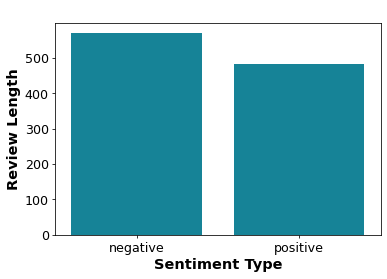

In [299]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 4), dpi=70)
bar1_plot=sns.barplot(mean_sentiment['sentiment'],mean_sentiment['review_len'],color='#0092AD')
bar1_plot.tick_params(pad=3,labelsize=13,rotation=0)
bar1_plot.set_xlabel('Sentiment Type',size=15,c='black',fontweight='bold')
bar1_plot.set_ylabel('Review Length',size=15,c='black',fontweight='bold')
bar1_plot.set_title('  ',size=15,c='black',fontweight='bold')
;

In [300]:
#pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [301]:
df3['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

C:\Users\rawan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='review_len'>

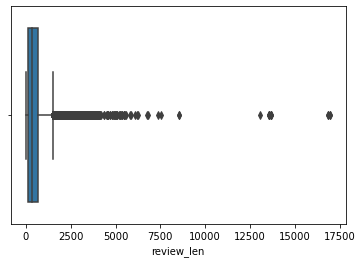

In [302]:
# checking outliers
sns.boxplot(df3.review_len)

In [303]:
# Removing outliers
q3= df3.review_len.quantile(q=0.75)
q1= df3.review_len.quantile(q=0.25)
Iqr = q3 - q1 
upper = (q3 + 1.5 * Iqr) 
lower = (q1 - 1.5 * Iqr) 
print(lower)
print(upper)

-710.0
1506.0


In [304]:
df3 = df3[df3['review_len'] < upper]

In [305]:
df3 = df3[lower<df3['review_len']]

C:\Users\rawan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='review_len'>

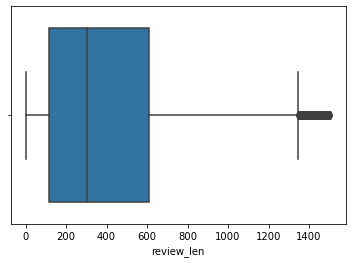

In [306]:
sns.boxplot(df3.review_len)

In [307]:
df3['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

In [308]:
df3.sentiment.value_counts(normalize=True)

positive    0.802989
negative    0.197011
Name: sentiment, dtype: float64

In [309]:
df3.sentiment.value_counts()

positive    20844
negative     5114
Name: sentiment, dtype: int64

In [315]:
df3

verified      reviewerID        asin           reviewerName  \
0          True  A2HOI48JK8838M  B00004U9V2                     DB   
1          True  A1YIPEY7HX73S7  B00004U9V2                  Ajaey   
2          True  A2QCGHIJ2TCLVP  B00004U9V2               D. Jones   
3          True  A2R4UNHFJBA6PY  B00004U9V2        Amazon Customer   
4          True  A2QCGHIJ2TCLVP  B00004U9V2               D. Jones   
...         ...             ...         ...                    ...   
34273     False  A2CF66KIQ3RKX3  B01GOZ61O8           Vivian Deliz   
34274     False  A1LKOIZXPQ9VG0  B01GOZ61O8               Elisa 20   
34275      True   AV2RWORXTFRJU  B01H353HUY            Gapeachmama   
34276     False  A22S7D0LP8GRDH  B01H353HUY  Jacob and Kiki Hantla   
34277      True   AAF5D1LTFGB7L  B01HGSJPMW          Libby Johnson   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
34273  I like to use moisturizers and sunscreens that...   
34274  I wouldn't be able to afford this if not asked...   
34275                                        Did nothing   
34276  I love the Oribe bright blonde radiance spray....   
34277                 I love all of the Elemis products.   

                                                 summary unixReviewTime  \
0                                    Beautiful Fragrance     01-05-2018   
1                                  wonderful hand lotion     04-05-2017   
2                                 Best hand cream around     03-27-2017   
3                                             Five Stars     03-20-2017   
4                                     Great hand lotion!     02-28-2017   
...                                                  ...            ...   
34273         Works great as a moisturizer and sunscreen     09-03-2017   
34274  Nice skin care product and sunscreen if you do...     09-03-2017   
34275                                           One Star     08-25-2017   
34276                                     No more brass!     07-08-2017   
34277                                         Five Stars     07-09-2018   

                                        Clean_reviewText sentiment  \
0      this handcream ha beautiful fragrance it doesn...  positive   
1      wonderful hand lotion for seriously dry skin s...  positive   
2      best hand cream around silky thick soak in all...  positive   
3                                                 thanks  positive   
4      great hand lotion soak right in and leaf skin ...  positive   
...                                                  ...       ...   
34273  like to use moisturizers and sunscreen that ha...  positive   
34274  wouldnt be able to afford this if not asked to...  positive   
34275                                        did nothing  negative   
34276  love the tribe bright blonde radiance spray iv...  positive   
34277                      love all of the enemy product  positive   

       review_len  word_count  
0             125          21  
1             187          34  
2              85          15  
3               8           1  
4              95          16  
...           ...         ...  
34273         448          93  
34274         744         142  
34275          11           2  
34276         262          46  
34277          34           7  

[25958 rows x 11 columns]

# Modeling:

In [316]:
#df3=df3.sample(10000)
df3=df3.head(10000)

In [355]:
df3.head(10000)

verified      reviewerID        asin     reviewerName  \
0          True  A2HOI48JK8838M  B00004U9V2               DB   
1          True  A1YIPEY7HX73S7  B00004U9V2            Ajaey   
2          True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
3          True  A2R4UNHFJBA6PY  B00004U9V2  Amazon Customer   
4          True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
...         ...             ...         ...              ...   
17195     False   ABLLHG0REGFX7  B004XHOBAG           Zellie   
17196     False  A1E8XXAKINL0B1  B004XHOBAG    Heather LaRee   
17197     False  A3CHMHGSJSQ02J  B004XHOBAG         ThatGirl   
17198     False  A2HZ3Z494VS1KG  B004XHOBAG   g3 from the UP   
17199     False  A1LINA8MCSONQL  B004XHOBAG         Radar626   

                                              reviewText  \
0      This handcream has a beautiful fragrance. It d...   
1      wonderful hand lotion, for seriously dry skin,...   
2      Best hand cream around.  Silky, thick, soaks i...   
3                                               Thanks!!   
4      Great hand lotion.  Soaks right in and leaves ...   
...                                                  ...   
17195  Looking at all of these reviews, everyone seem...   
17196  I'm not a daily face-make up kind of gal, but ...   
17197  I should have gleaned from the name that "Gold...   
17198  when i first put this product on my face, it m...   
17199  As someone with very fair skin, it can be hard...   

                                             summary unixReviewTime  \
0                                Beautiful Fragrance     01-05-2018   
1                              wonderful hand lotion     04-05-2017   
2                             Best hand cream around     03-27-2017   
3                                         Five Stars     03-20-2017   
4                                 Great hand lotion!     02-28-2017   
...                                              ...            ...   
17195           I feel like I'm missing something...     05-16-2014   
17196  Smooth application with a light, lovely tint.     05-15-2014   
17197                        Nice tinted moisturizer     05-15-2014   
17198                             has its advantages     05-15-2014   
17199                          Gives wonderful color     05-15-2014   

                                        Clean_reviewText sentiment  \
0      this handcream ha beautiful fragrance it doesn...  positive   
1      wonderful hand lotion for seriously dry skin s...  positive   
2      best hand cream around silky thick soak in all...  positive   
3                                                 thanks  positive   
4      great hand lotion soak right in and leaf skin ...  positive   
...                                                  ...       ...   
17195  looking at all of these review everyone seems ...  negative   
17196  im not daily face make up kind of gal but real...  positive   
17197  should have gleaned from the name that golden ...  positive   
17198  when first put this product on my face it made...  positive   
17199  someone with very fair skin it can be hard to ...  positive   

       review_len  word_count  label  
0             125          21  other  
1             187          34   skin  
2              85          15   skin  
3               8           1  other  
4              95          16   skin  
...           ...         ...    ...  
17195         919         174         
17196         195          37         
17197         570         108         
17198         781         151         
17199         920         166         

[10000 rows x 12 columns]

In [318]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),max_df=0.90,min_df = 3)
cv_matrix = cv.fit_transform(df3['Clean_reviewText'])
cv_array = cv_matrix.toarray()
df_vec = pd.DataFrame(data=cv_array,columns = cv.get_feature_names())
df_vec

ability  able  able achieve  able come  able find  able fix  able fully  \
0           0     0             0          0          0         0           0   
1           0     0             0          0          0         0           0   
2           0     0             0          0          0         0           0   
3           0     0             0          0          0         0           0   
4           0     0             0          0          0         0           0   
...       ...   ...           ...        ...        ...       ...         ...   
9995        0     0             0          0          0         0           0   
9996        0     0             0          0          0         0           0   
9997        0     0             0          0          0         0           0   
9998        0     0             0          0          0         0           0   
9999        0     0             0          0          0         0           0   

      able keep  able longer  able remove  ...  zinc oxide  zit  zit problem  \
0             0            0            0  ...           0    0            0   
1             0            0            0  ...           0    0            0   
2             0            0            0  ...           0    0            0   
3             0            0            0  ...           0    0            0   
4             0            0            0  ...           0    0            0   
...         ...          ...          ...  ...         ...  ...          ...   
9995          0            0            0  ...           0    0            0   
9996          0            0            0  ...           0    0            0   
9997          0            0            0  ...           0    0            0   
9998          0            0            0  ...           0    0            0   
9999          0            0            0  ...           0    0            0   

      zone  zone dry  zoya  zoya always  zoya application  zoya easy  \
0        0         0     0            0                 0          0   
1        0         0     0            0                 0          0   
2        0         0     0            0                 0          0   
3        0         0     0            0                 0          0   
4        0         0     0            0                 0          0   
...    ...       ...   ...          ...               ...        ...   
9995     0         0     0            0                 0          0   
9996     0         0     0            0                 0          0   
9997     0         0     0            0                 0          0   
9998     0         0     0            0                 0          0   
9999     0         0     0            0                 0          0   

      zoya nail  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
9995          0  
9996          0  
9997          0  
9998          0  
9999          0  

[10000 rows x 16592 columns]

In [319]:
df_vec.sum(0).sort_values(ascending=False)[:15]


skin      4390
hair      1759
face      1741
nail      1530
dry       1368
smell     1262
scent     1258
cream     1223
coat      1053
even      1010
light      949
makeup     936
bottle     813
pretty     790
apply      785
dtype: int64

In [320]:
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),max_df=0.90,min_df = 3)
tfidf_matrix = tfidf_vec.fit_transform(df3['Clean_reviewText'])
tfidf_array = tfidf_matrix.toarray()
df_tfidf = pd.DataFrame(data=tfidf_array,columns = tfidf_vec.get_feature_names())
df_tfidf

ability  able  able achieve  able come  able find  able fix  able fully  \
0         0.0   0.0           0.0        0.0        0.0       0.0         0.0   
1         0.0   0.0           0.0        0.0        0.0       0.0         0.0   
2         0.0   0.0           0.0        0.0        0.0       0.0         0.0   
3         0.0   0.0           0.0        0.0        0.0       0.0         0.0   
4         0.0   0.0           0.0        0.0        0.0       0.0         0.0   
...       ...   ...           ...        ...        ...       ...         ...   
9995      0.0   0.0           0.0        0.0        0.0       0.0         0.0   
9996      0.0   0.0           0.0        0.0        0.0       0.0         0.0   
9997      0.0   0.0           0.0        0.0        0.0       0.0         0.0   
9998      0.0   0.0           0.0        0.0        0.0       0.0         0.0   
9999      0.0   0.0           0.0        0.0        0.0       0.0         0.0   

      able keep  able longer  able remove  ...  zinc oxide  zit  zit problem  \
0           0.0          0.0          0.0  ...         0.0  0.0          0.0   
1           0.0          0.0          0.0  ...         0.0  0.0          0.0   
2           0.0          0.0          0.0  ...         0.0  0.0          0.0   
3           0.0          0.0          0.0  ...         0.0  0.0          0.0   
4           0.0          0.0          0.0  ...         0.0  0.0          0.0   
...         ...          ...          ...  ...         ...  ...          ...   
9995        0.0          0.0          0.0  ...         0.0  0.0          0.0   
9996        0.0          0.0          0.0  ...         0.0  0.0          0.0   
9997        0.0          0.0          0.0  ...         0.0  0.0          0.0   
9998        0.0          0.0          0.0  ...         0.0  0.0          0.0   
9999        0.0          0.0          0.0  ...         0.0  0.0          0.0   

      zone  zone dry  zoya  zoya always  zoya application  zoya easy  \
0      0.0       0.0   0.0          0.0               0.0        0.0   
1      0.0       0.0   0.0          0.0               0.0        0.0   
2      0.0       0.0   0.0          0.0               0.0        0.0   
3      0.0       0.0   0.0          0.0               0.0        0.0   
4      0.0       0.0   0.0          0.0               0.0        0.0   
...    ...       ...   ...          ...               ...        ...   
9995   0.0       0.0   0.0          0.0               0.0        0.0   
9996   0.0       0.0   0.0          0.0               0.0        0.0   
9997   0.0       0.0   0.0          0.0               0.0        0.0   
9998   0.0       0.0   0.0          0.0               0.0        0.0   
9999   0.0       0.0   0.0          0.0               0.0        0.0   

      zoya nail  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
9995        0.0  
9996        0.0  
9997        0.0  
9998        0.0  
9999        0.0  

[10000 rows x 16592 columns]

In [321]:
# function for displaying the words in each topic to be used for all models
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [322]:
from sklearn.decomposition import TruncatedSVD
lsa_model= TruncatedSVD(4)
lsa_Topics = lsa_model.fit_transform(tfidf_matrix)

In [323]:
display_topics(lsa_model, tfidf_vec.get_feature_names(), 20) 


Topic  0
skin, hair, face, nail, dry, smell, cream, scent, pretty, coat, makeup, light, even, beautiful, sensitive, best, hand, apply, perfect, clean

Topic  1
beautiful, nail, coat, shellac, pink, shade, beautiful shade, pretty, blue, favorite, top, perfect, wear, top coat, dark, brand, two, two coat, beautiful dark, bright

Topic  2
nail, coat, pretty, shellac, pink, top, perfect, top coat, hair, base, favorite, chip, wear, base coat, two, manicure, compliment, shade, bright, red

Topic  3
hair, shampoo, smell, conditioner, dryer, thinning, iron, tribe, curl, stuff, dry hair, fiber, thinning hair, scalp, blow, curling, heat, fine, topic, hold


# LDA Model:

In [324]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(5)
lda_Topics = lda_model.fit_transform(cv_matrix)

In [325]:
display_topics(lda_model, cv.get_feature_names(), 30)


Topic  0
skin, face, sensitive, dry, makeup, water, cleanser, clean, cream, sensitive skin, oily, wash, moisturizer, feeling, bottle, even, acne, tried, sunscreen, remove, toner, smell, scent, facial, without, since, gentle, dry skin, remover, leaf

Topic  1
scent, smell, cream, skin, hand, fragrance, say, perfume, think, first, way, give, try, see, didnt, bottle, still, soap, better, even, find, light, dry, strong, something, star, tried, around, expensive, tube

Topic  2
skin, powder, coverage, cover, dark, apply, makeup, face, light, dermablend, shade, tone, easy, blend, spot, skin tone, dry, even, natural, setting, smooth, easily, sun, application, spy, come, way, setting powder, moisturizer, better

Topic  3
nail, coat, shellac, pink, pretty, top, perfect, two, light, wear, top coat, base, shade, chip, beautiful, even, easy, hand, best, apply, looking, first, still, red, manicure, dry, favorite, tried, bright, put

Topic  4
hair, lip, shampoo, dry, beautiful, balm, bought, red, b

# Corex Model:
> we were able to get the topics from this model.

In [326]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

In [327]:
words = list(np.asarray(cv.get_feature_names()))
topic_model = ct.Corex(n_hidden=10, words=words,seed=42)
topic_model.fit(cv_matrix, words=words, docs=df3['Clean_reviewText'])

In [328]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: skin,face,sensitive,makeup,sensitive skin,cream,say,try,didnt,tried
1: scent,clean,feeling,dry,smell,oily,fragrance,cleanser,water,greasy
2: even,first,small,apply,amount,come,way,better,find,give
3: coverage,dermablend,cover,powder,dark,tone,skin tone,blend,shade,easy
4: hair,see,still,thing,think,could,something,perfume,made,never
5: nail,coat,shellac,manicure,base,chip,base coat,two coat,two,opaque
6: balm,strong,men,lip balm,foot,husband,lip,overpowering,mist,cologne
7: jane,jane regale,regale,pink,red,fast,blade,thinning,topic,razor
8: top,top coat,iron,curl,curling,curling iron,mario badest,badest,mario,cystic
9: hand,difference,moisturizing,hand cream,see difference,read,shea,butter,within,shea butter


In [329]:
words = list(np.asarray(tfidf_vec.get_feature_names()))
topic_model_2 = ct.Corex(n_hidden=3, words=words,seed=42)
topic_model_2.fit(tfidf_matrix, words=words, docs=df3['Clean_reviewText'])

In [330]:
# Print all topics from the CorEx topic model
topics = topic_model_2.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: skin,nail,coat,hair,beautiful,face,shellac,pink,cream,sensitive
1: dermablend,powder,cover,coverage,setting powder,setting,blend,cover creme,creme,full coverage
2: scent,perfume,fragrance,floral,sweet,cologne,obsession,note,eternity,eau


In [331]:
# trying with anchors to find topics that make sence
# first try
topic_model_2 = ct.Corex(n_hidden=10, words=words,
                       max_iter=200, verbose=False, seed=42)

topic_model_2.fit(tfidf_matrix, words=words, docs=df3['Clean_reviewText'], 
                anchors=[["skin", "makeup"],
    ["price"],
    ["nail", "polish"],
    ["hair", "spray"],
    ["cream"],
    ['price'],
    ['brow']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model_2.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: skin,makeup,face,sensitive,sensitive skin,cleanser,oily,beautiful,powder,dry skin
1: nail,coat,shellac,top coat,manicure,top,base coat,base,chip,opaque
2: hair,shampoo,iron,dryer,conditioner,thinning,curling,curl,curling iron,dry hair
3: cream,link,hand cream,hand,shaving,proviso,linked,linked class,data hookproduct,class link
4: brow,described,received quickly,advertised received,fast shipping,shipping,original shellac,shellac described,arrived,perfect condition
5: stuffer,stocking stuffer,stocking,acetone remover,sat,sample size,sample pack,saffron,ruining,rubbing remove
6: hydro salve,california hydro,salve lip,absorbs fast,scale,saw result,satisfied purchase,sadly,rosewood,ritual
7: scent,perfume,floral,fragrance,cologne,sweet,obsession,note,smell,eternity
8: accelerator,raspberry,raise,quite thought,quite small,quick spritz,put night,put light,pump pump,proved
9: pink,red,purple,dark pink,dark,dark blue,blue,pink expected,shade,shimmer


In [332]:
# Second try
topic_model= ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=42)

topic_model.fit(tfidf_matrix, words=words, docs=df3['Clean_reviewText'], 
                anchors=[["skin", "cream","dry"],
    ["nail"],
    ['makeup'],
    ['hair', 'scalp']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: skin,cream,dry,face,sensitive,cleanser,sensitive skin,oily,dry skin,beautiful
1: nail,coat,top coat,shellac,manicure,top,base coat,base,french,opaque
2: makeup,powder,dermablend,link,setting powder,cover,setting,coverage,linked,hookproduct
3: hair,scalp,shampoo,iron,conditioner,dryer,thinning,curling,curl,curling iron
4: scent,perfume,floral,fragrance,cologne,sweet,obsession,smell,note,eternity
5: described,shipping,fast shipping,received quickly,fast,advertised received,transaction,original shellac,shellac described,perfect condition


In [459]:
topis1=topic_model.get_topics()
topis1

[[('skin', 0.141487759373279, 1.0),
  ('cream', 0.06553693682043031, 1.0),
  ('dry', 0.021093721385977225, 1.0),
  ('face', 0.009381546728841601, 1.0),
  ('sensitive', 0.006857898236188484, 1.0),
  ('cleanser', 0.006578187521186314, 1.0),
  ('sensitive skin', 0.00645989027533016, 1.0),
  ('oily', 0.005342390151577804, 1.0),
  ('dry skin', 0.004595812852884433, 1.0),
  ('beautiful', 0.004555050985781317, -1.0)],
 [('nail', 0.23518897426501886, 1.0),
  ('coat', 0.013616988723913858, 1.0),
  ('top coat', 0.00548906701771429, 1.0),
  ('shellac', 0.005197716837903701, 1.0),
  ('manicure', 0.004019605172120215, 1.0),
  ('top', 0.00340362082774878, 1.0),
  ('base coat', 0.0032712407099640215, 1.0),
  ('base', 0.00304304686288947, 1.0),
  ('french', 0.0029027021276524768, 1.0),
  ('opaque', 0.0025405022481761598, 1.0)],
 [('makeup', 0.037451314462639905, 1.0),
  ('powder', 0.007955010283667184, 1.0),
  ('dermablend', 0.0070994382765354035, 1.0),
  ('link', 0.0051532698564297095, 1.0),
  ('sett

In [335]:
topic_model.clusters.shape

(16592,)

In [356]:
df3.reset_index(drop=True, inplace=True)

In [357]:
# testing the topics 
predictions = pd.DataFrame(topic_model.predict(tfidf_matrix), columns=['skin', 'nail', 'makeup', 'hair','delivery','scent'])
predictions

skin   nail  makeup   hair  delivery  scent
0     False  False   False  False     False  False
1      True  False   False  False     False  False
2      True  False   False  False     False  False
3     False  False   False  False     False  False
4      True  False   False  False     False  False
...     ...    ...     ...    ...       ...    ...
9995  False  False    True  False     False  False
9996   True  False   False  False     False  False
9997   True  False   False  False     False  False
9998  False  False   False  False     False  False
9999   True  False   False  False     False  False

[10000 rows x 6 columns]

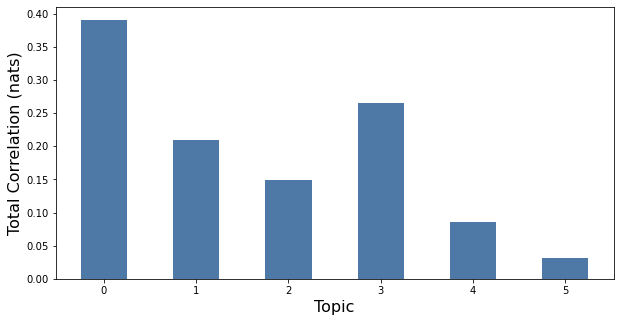

In [358]:
columns=['skin', 'nail', 'makeup', 'hair','described','scent']
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4E79A7', width=.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

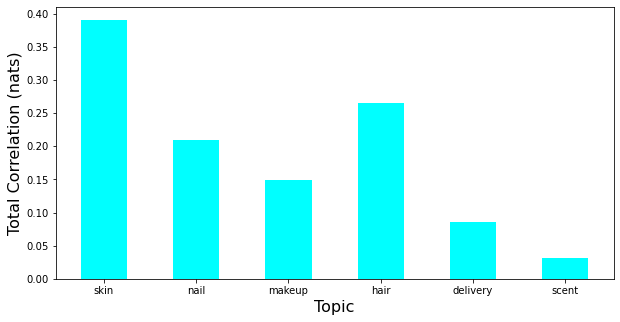

In [440]:
columns=['skin', 'nail', 'makeup', 'hair','delivery','scent']
plt.figure(figsize=(10,5))
plt.bar(columns, topic_model.tcs, color= [0,1,1], width=.5)
#plt.xticks(columns)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [359]:
df3['label']=''

In [366]:
df3.head(50)

verified      reviewerID        asin                 reviewerName  \
0       True  A2HOI48JK8838M  B00004U9V2                           DB   
1       True  A1YIPEY7HX73S7  B00004U9V2                        Ajaey   
2       True  A2QCGHIJ2TCLVP  B00004U9V2                     D. Jones   
3       True  A2R4UNHFJBA6PY  B00004U9V2              Amazon Customer   
4       True  A2QCGHIJ2TCLVP  B00004U9V2                     D. Jones   
5       True  A1606LA683WZZU  B00004U9V2                          Amr   
6      False  A1YY53NQXFKMRN  B00004U9V2                       Trixie   
7       True  A3R0NQ9E53JHYQ  B00004U9V2                     T. Hooth   
8       True  A2QCGHIJ2TCLVP  B00004U9V2                     D. Jones   
9       True  A35YXEDATMIJ9S  B00004U9V2                         asma   
10      True  A2HOI48JK8838M  B00004U9V2                           DB   
11     False  A3CRJ1Q73RB25F  B00004U9V2                      Annie T   
12      True  A1Y39RECFXEGNL  B00004U9V2                          Art   
13      True  A1Y39RECFXEGNL  B00004U9V2                          Art   
14      True  A3O0BXK3SZ6FE0  B00004U9V2                       Newman   
15      True   AWVF9EWW3BXYV  B00004U9V2                          A_V   
16      True   AWVF9EWW3BXYV  B00004U9V2                          A_V   
17      True  A1Y39RECFXEGNL  B00004U9V2                          Art   
18      True   ACUGBCEADYT6D  B00004U9V2                     Booklass   
19      True  A3O0BXK3SZ6FE0  B00004U9V2                       Newman   
20     False  A3S3R88HA0HZG3  B00004U9V2                   PT Cruiser   
21      True  A1RRX286ZRI830  B00005V50B                     Patrycja   
22      True  A2CAF6DVZOHMHG  B00005V50B                      Marlene   
23     False  A1M1Y5UGONAW06  B00005V50B                         Jody   
24      True   AHLTB5YPI6JX1  B00005V50B                Dame de Drama   
25      True  A3LSOG7F3ZCJ65  B00005V50B                    glam girl   
26     False  A2NUBL2UYWPBWR  B00005V50B                            C   
27      True  A2AVMDTFW79N2N  B000068DWY                    Michael R   
28      True  A2KJIX9GXBCVWH  B000068DWY                Rohini Atresh   
29      True  A15R5T6T1TBSJX  B000068DWY              Amazon Customer   
30      True  A3TX3N3YORDUBY  B000068DWY                          MRM   
31      True  A3045PONRA3KZ2  B000068DWY             Anthony Santiago   
32      True  A326D766H2I6RR  B000068DWY  JEAN PIERRE PRETELT MAYORGA   
33      True  A1B95QB8NVYOSM  B000068DWY                        Tessa   
34      True  A1EJ9DSKSM0UN1  B000068DWY              lookupatthemoon   
35      True  A2N0ORB4ES548E  B000068DWY          LAURENCE E WILLIAMS   
36      True  A2N0ORB4ES548E  B000068DWY          LAURENCE E WILLIAMS   
37      True   AC400LZPY74N1  B000068DWY                      Carolyn   
38      True   AV00VR0BWTQI6  B000068DWY                       Kilian   
39     False  A32O98PFC3OP7K  B000068DWY             A Gamer at Heart   
40     False   A6QG9LM5WL0AQ  B000068DWY                     C. Irish   
41     False   AOP2ZRNSHY2Z3  B000068DWY            Andrew D. Lossing   
42     False  A2JP9E1H0SF392  B000068DWY                       TobycW   
43     False  A3IOCPLIMYDBCD  B000068DWY                Hummingbirder   
44     False    AG0830H1DBLD  B000068DWY   VS Grenier Amazon Customer   
45     False  A2JCJJNY43QQIV  B000068DWY                    Katy Lake   
46      True  A3UQ3HOJ37Q24Q  B000068DWY                    Squirrely   
47      True  A2MS6GT9F0CB01  B000068DWY                          KMS   
48      True  A18L008KVHQ1AM  B000068DWY                   Trump 2020   
49      True   AICOFZH7HCKGY  B000068DWY                    tangolady   

                                           reviewText  \
0   This handcream has a beautiful fragrance. It d...   
1   wonderful hand lotion, for seriously dry skin,...   
2   Best hand cream around.  Silky, thick, soaks i...   
3                                            Thanks!

# cluster:

In [570]:
from sklearn.decomposition import TruncatedSVD
svd2 = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd2.fit(cv_array)
svdfeatures=svd2.transform(cv_array)

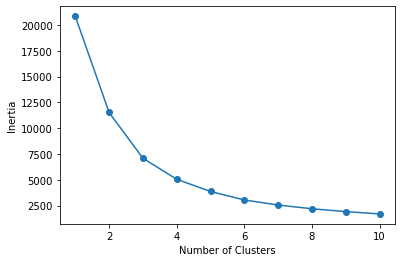

In [571]:
import matplotlib.pyplot as plt
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(svdfeatures)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [572]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

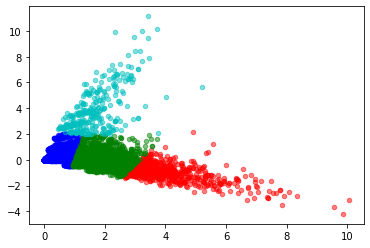

In [573]:
num_clusters=4
km=KMeans(n_clusters=num_clusters)
km.fit(svdfeatures)
prediction = km.predict(svdfeatures)
display_cluster(svdfeatures,km,num_clusters)

In [237]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [238]:
new_df= get_top_features_cluster(cv_array, prediction, 30)

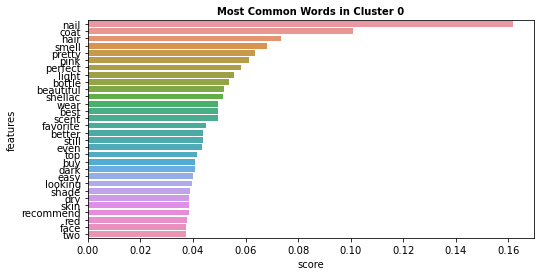

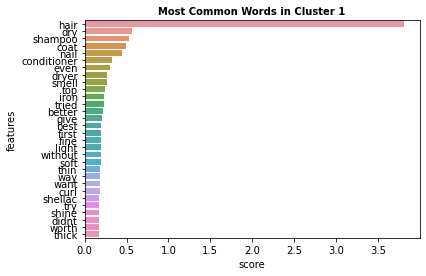

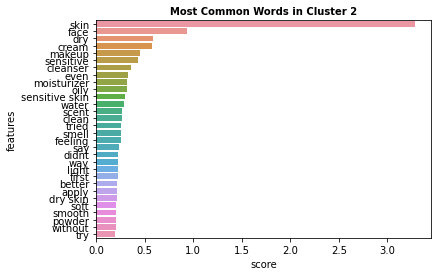

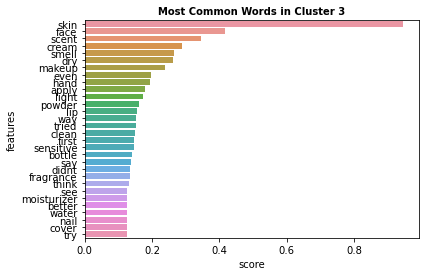

In [239]:
plotWords(new_df, 30)

# Spacy:

In [538]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [539]:
df3['spacy_doc'] = list(nlp.pipe(df3.Clean_reviewText))

In [540]:
df3

verified      reviewerID        asin     reviewerName  \
0         True  A2HOI48JK8838M  B00004U9V2               DB   
1         True  A1YIPEY7HX73S7  B00004U9V2            Ajaey   
2         True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
3         True  A2R4UNHFJBA6PY  B00004U9V2  Amazon Customer   
4         True  A2QCGHIJ2TCLVP  B00004U9V2         D. Jones   
...        ...             ...         ...              ...   
9995     False   ABLLHG0REGFX7  B004XHOBAG           Zellie   
9996     False  A1E8XXAKINL0B1  B004XHOBAG    Heather LaRee   
9997     False  A3CHMHGSJSQ02J  B004XHOBAG         ThatGirl   
9998     False  A2HZ3Z494VS1KG  B004XHOBAG   g3 from the UP   
9999     False  A1LINA8MCSONQL  B004XHOBAG         Radar626   

                                             reviewText  \
0     This handcream has a beautiful fragrance. It d...   
1     wonderful hand lotion, for seriously dry skin,...   
2     Best hand cream around.  Silky, thick, soaks i...   
3                                              Thanks!!   
4     Great hand lotion.  Soaks right in and leaves ...   
...                                                 ...   
9995  Looking at all of these reviews, everyone seem...   
9996  I'm not a daily face-make up kind of gal, but ...   
9997  I should have gleaned from the name that "Gold...   
9998  when i first put this product on my face, it m...   
9999  As someone with very fair skin, it can be hard...   

                                            summary unixReviewTime  \
0                               Beautiful Fragrance     01-05-2018   
1                             wonderful hand lotion     04-05-2017   
2                            Best hand cream around     03-27-2017   
3                                        Five Stars     03-20-2017   
4                                Great hand lotion!     02-28-2017   
...                                             ...            ...   
9995           I feel like I'm missing something...     05-16-2014   
9996  Smooth application with a light, lovely tint.     05-15-2014   
9997                        Nice tinted moisturizer     05-15-2014   
9998                             has its advantages     05-15-2014   
9999                          Gives wonderful color     05-15-2014   

                                       Clean_reviewText sentiment  review_len  \
0     this handcream ha beautiful fragrance it doesn...  positive         125   
1     wonderful hand lotion for seriously dry skin s...  positive         187   
2     best hand cream around silky thick soak in all...  positive          85   
3                                                thanks  positive           8   
4     great hand lotion soak right in and leaf skin ...  positive          95   
...                                                 ...       ...         ...   
9995  looking at all of these review everyone seems ...  negative         919   
9996  im not daily face make up kind of gal but real...  positive         195   
9997  should have gleaned from the name that golden ...  positive         570   
9998  when first put this product on my face it made...  positive         781   
9999  someone with very fair skin it can be hard to ...  positive         920   

      word_count   label                                          spacy_doc  
0             21   other  (this, handcream, ha, beautiful, fragrance, it...  
1             34    skin  (wonderful, hand, lotion, for, seriously, dry,...  
2             15    skin  (best, hand, cream, around, silky, thick, soak...  
3              1   other                                           (thanks)  
4             16    skin  (great, hand, lotion, soak, right, in, and, le...  
...          ...     ...                                                ...  
9995         174  makeup  (looking, at, all, of, these, review, everyone...  
9996          37    skin  (i, m, not, daily, face, make, up, kind, of, g...  
9997         108    skin

In [541]:
positive_reviews = df3[df3.sentiment=='positive']
negative_reviews = df3[df3.sentiment=='negative']

In [542]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [543]:
from collections import Counter

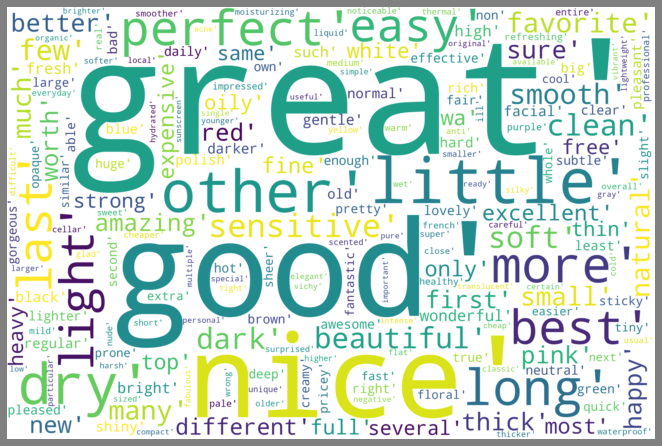

In [544]:
from wordcloud import WordCloud
text = pos_adj
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    collocations=False,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [545]:
stop_words2=['good','nice', 'more', 'great', 'other', 'better', 'first', 'sure','pink']

In [546]:
neg_adj = pd.DataFrame(neg_adj)
neg_adj = neg_adj.apply(lambda x: ' '.join([word for word in x if word not in (stop_words2)]))
neg_adj= list(neg_adj)

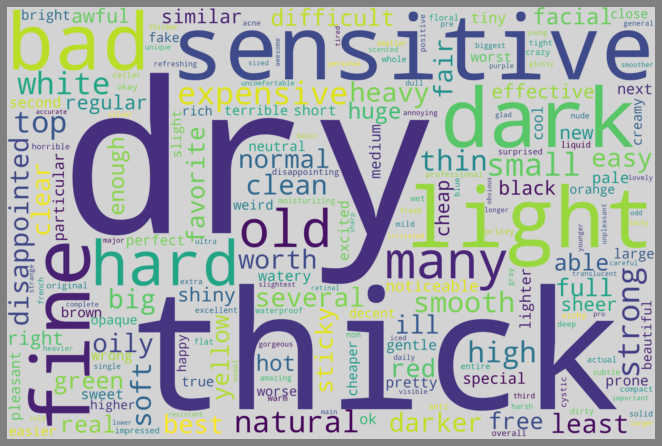

In [547]:
from wordcloud import WordCloud
text = neg_adj
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    collocations=False,
    background_color = 'lightgrey',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [548]:
Counter(pos_adj).most_common(30)

[('great', 2365),
 ('good', 1522),
 ('nice', 1101),
 ('little', 1034),
 ('other', 876),
 ('dry', 815),
 ('more', 642),
 ('long', 638),
 ('perfect', 605),
 ('last', 578),
 ('best', 572),
 ('light', 556),
 ('easy', 536),
 ('sensitive', 530),
 ('soft', 462),
 ('clean', 451),
 ('dark', 437),
 ('beautiful', 429),
 ('few', 418),
 ('smooth', 408),
 ('favorite', 393),
 ('many', 376),
 ('natural', 358),
 ('small', 353),
 ('much', 353),
 ('sure', 330),
 ('better', 324),
 ('thick', 314),
 ('first', 311),
 ('pink', 304)]

In [550]:
Counter(pos_noun).most_common(30)

[('product', 3968),
 ('color', 3711),
 ('skin', 3626),
 ('hair', 1381),
 ('face', 1371),
 ('day', 1241),
 ('nail', 1215),
 ('time', 1179),
 ('cream', 984),
 ('scent', 978),
 ('love', 975),
 ('eye', 962),
 ('polish', 901),
 ('makeup', 779),
 ('coat', 767),
 ('week', 619),
 ('year', 600),
 ('bottle', 592),
 ('hand', 589),
 ('bit', 564),
 ('way', 553),
 ('smell', 548),
 ('lot', 524),
 ('one', 500),
 ('price', 495),
 ('line', 495),
 ('coverage', 492),
 ('work', 491),
 ('brand', 485),
 ('powder', 482)]

In [551]:
Counter(neg_noun).most_common(30)

[('product', 995),
 ('color', 815),
 ('skin', 756),
 ('hair', 366),
 ('face', 325),
 ('nail', 289),
 ('scent', 266),
 ('eye', 260),
 ('polish', 255),
 ('day', 252),
 ('coat', 250),
 ('time', 249),
 ('cream', 223),
 ('bottle', 213),
 ('price', 166),
 ('smell', 165),
 ('makeup', 151),
 ('way', 149),
 ('hand', 147),
 ('one', 146),
 ('lip', 138),
 ('bit', 134),
 ('line', 131),
 ('lot', 126),
 ('water', 119),
 ('thing', 117),
 ('result', 109),
 ('powder', 107),
 ('oil', 106),
 ('foundation', 105)]

In [552]:
# Here we added a new column with label of the predicted topics for each review
for l in range(10000):
    if predictions['nail'][l]==True:
        df3['label'][l]='nail'
    elif predictions['hair'][l]==True:
        df3['label'][l]='hair' 
    elif predictions['skin'][l]==True:
        df3['label'][l]='skin'
    elif predictions['makeup'][l]==True:
        df3['label'][l]='makeup'
    elif predictions['delivery'][l]==True:
        df3['label'][l]='delivery' 
    elif predictions['scent'][l]==True:
        df3['label'][l]='scent' 
    else :
        df3['label'][l]='other'

In [553]:
len(df3)

10000

In [554]:
df3['label'].value_counts()

other       4517
skin        2838
nail        1213
hair         721
delivery     294
makeup       275
scent        142
Name: label, dtype: int64

In [555]:
nail_label = df3[df3.label=='nail']
makeup_label = df3[df3.label=='makeup']
skin_label = df3[df3.label=='skin']
delivery_label = df3[df3.label=='delivery']
scent_label = df3[df3.label=='scent']
hair_label = df3[df3.label=='hair']
other_label = df3[df3.label=='other']

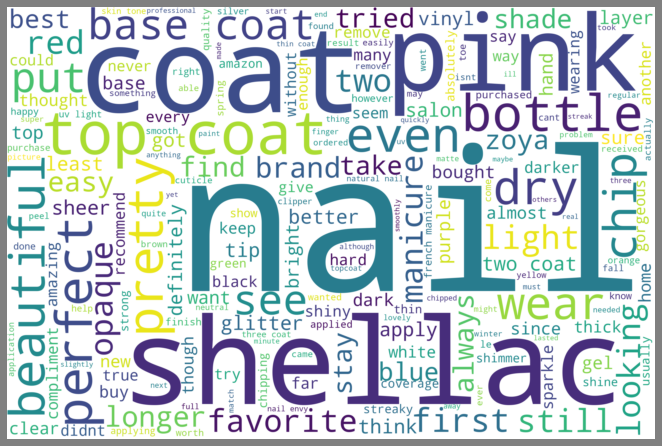

In [567]:
from wordcloud import WordCloud
text = list(nail_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

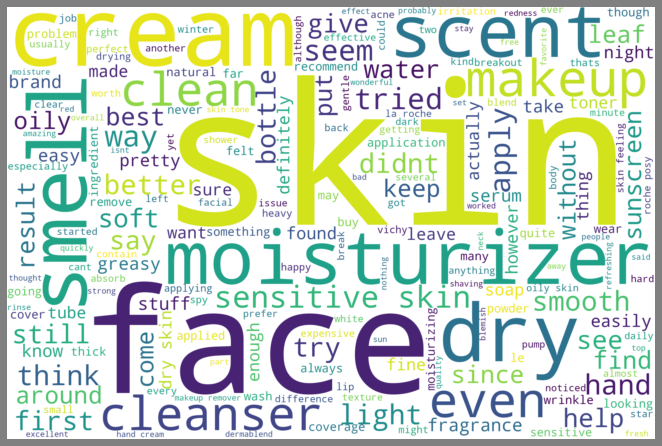

In [566]:
from wordcloud import WordCloud
text = list(skin_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

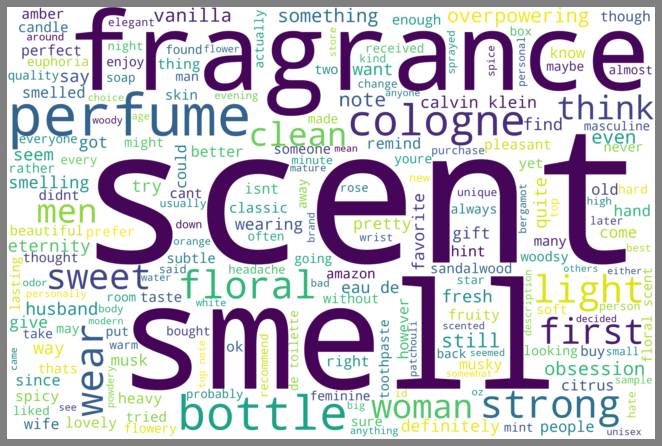

In [565]:
from wordcloud import WordCloud
text = list(delivery_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

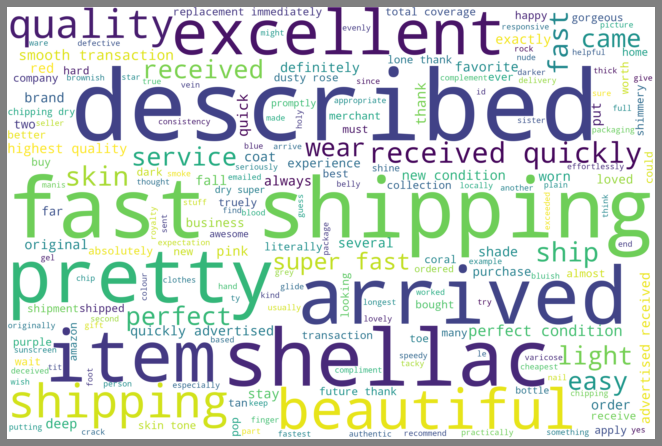

In [564]:
from wordcloud import WordCloud
text = list(scent_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

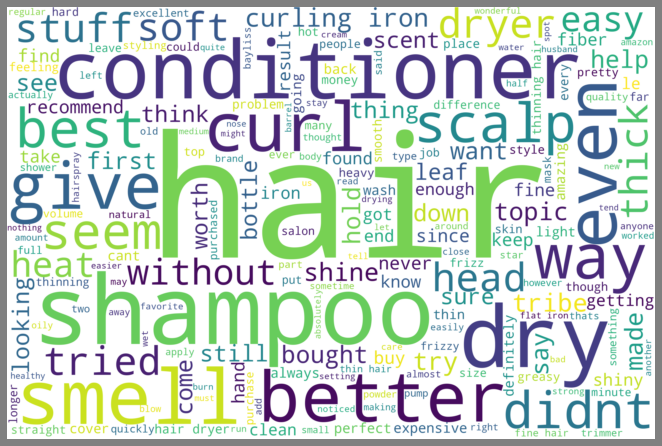

In [563]:
from wordcloud import WordCloud
text = list(hair_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

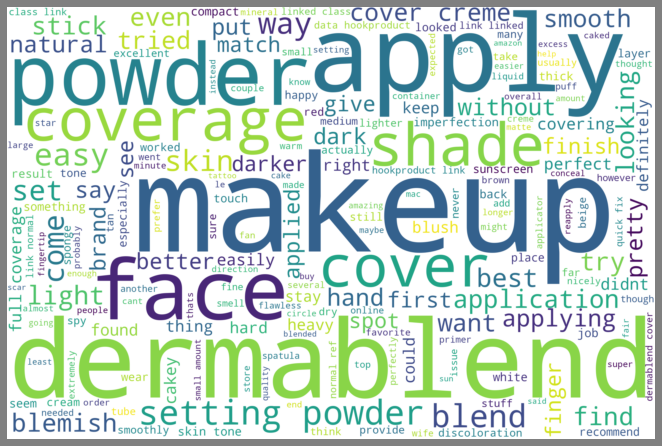

In [562]:
from wordcloud import WordCloud
text = list(makeup_label.spacy_doc)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (10,6),
    facecolor = 'grey',
    edgecolor = 'grey')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Classicfcation

In [394]:
# Split the data into X and y data sets
X = df3.Clean_reviewText
y = df3.sentiment.to_frame()
y=pd.get_dummies(y, drop_first=True)

In [396]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),max_df=0.90,min_df = 3)
cv_matrix = cv.fit_transform(X)
cv_array = cv_matrix.toarray()
df_vec = pd.DataFrame(data=cv_array,columns = cv.get_feature_names())
df_vec

ability  able  able achieve  able come  able find  able fix  able fully  \
0           0     0             0          0          0         0           0   
1           0     0             0          0          0         0           0   
2           0     0             0          0          0         0           0   
3           0     0             0          0          0         0           0   
4           0     0             0          0          0         0           0   
...       ...   ...           ...        ...        ...       ...         ...   
9995        0     0             0          0          0         0           0   
9996        0     0             0          0          0         0           0   
9997        0     0             0          0          0         0           0   
9998        0     0             0          0          0         0           0   
9999        0     0             0          0          0         0           0   

      able keep  able longer  able remove  ...  zinc oxide  zit  zit problem  \
0             0            0            0  ...           0    0            0   
1             0            0            0  ...           0    0            0   
2             0            0            0  ...           0    0            0   
3             0            0            0  ...           0    0            0   
4             0            0            0  ...           0    0            0   
...         ...          ...          ...  ...         ...  ...          ...   
9995          0            0            0  ...           0    0            0   
9996          0            0            0  ...           0    0            0   
9997          0            0            0  ...           0    0            0   
9998          0            0            0  ...           0    0            0   
9999          0            0            0  ...           0    0            0   

      zone  zone dry  zoya  zoya always  zoya application  zoya easy  \
0        0         0     0            0                 0          0   
1        0         0     0            0                 0          0   
2        0         0     0            0                 0          0   
3        0         0     0            0                 0          0   
4        0         0     0            0                 0          0   
...    ...       ...   ...          ...               ...        ...   
9995     0         0     0            0                 0          0   
9996     0         0     0            0                 0          0   
9997     0         0     0            0                 0          0   
9998     0         0     0            0                 0          0   
9999     0         0     0            0                 0          0   

      zoya nail  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
9995          0  
9996          0  
9997          0  
9998          0  
9999          0  

[10000 rows x 16592 columns]

In [397]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

In [400]:
from sklearn.decomposition import TruncatedSVD
svd2 = TruncatedSVD(n_components=1500, n_iter=7, random_state=42)
svd2.fit(cv_matrix)
svdfeatures=svd2.transform(cv_matrix)

In [401]:
svd_ratio=svd2.explained_variance_ratio_
sum(svd_ratio)

0.8642303449147509

In [402]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(svdfeatures, y, test_size=0.05, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=.052631, random_state=3)

# DecisionTreeClassifier

In [403]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
decisiontree = DecisionTreeClassifier(max_depth=11)
decisiontree.fit(X_train, y_train)
print("The score for decision tree ")
print("Training set is : {:6.2f}%".format(100*decisiontree.score(X_train, y_train)))
print("validation set is: {:6.2f}%".format(100*decisiontree.score(X_val, y_val)))
y_pred = decisiontree.predict(X_train)
print(f1_score(y_train, y_pred))
y_pred2 = decisiontree.predict(X_val)
print(f1_score(y_val, y_pred2))

The score for decision tree 
Training set is :  95.27%
validation set is:  80.00%
0.9716604576902608
0.8826291079812206


# LogisticRegression 

In [404]:
#LogisticRegression after CountVectorizer only 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
log_reg = LogisticRegression( C=1 )
log_reg.fit(X_train, y_train)
print("The score for logistic regression")
print("Training set is : {:6.2f}%".format(100*log_reg.score(X_train, y_train)))
print("validation set is: {:6.2f}%".format(100*log_reg.score(X_val, y_val)))
#print("logistic regression confusion matrix: \n\n", confusion_matrix(y_val, log_reg.predict(pcafeatures_val)))
y_pred = log_reg.predict(X_train)
print(f1_score(y_train, y_pred))
y_pred2 = log_reg.predict(X_val)
print(f1_score(y_val, y_pred2))

C:\Users\rawan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



The score for logistic regression
Training set is :  92.23%
validation set is:  86.60%
0.954232960125712
0.9220023282887078


C:\Users\rawan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Over sampler

In [405]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
# define dataset
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
X_val_over, y_val_over = oversample.fit_resample(X_val, y_val)

# summarize class distribution
print(Counter(y_train_over))

Counter({'sentiment_positive': 1})


In [406]:
y_train_over.sentiment_positive.value_counts()

0    7371
1    7371
Name: sentiment_positive, dtype: int64

In [407]:
y_val_over.sentiment_positive.value_counts()

0    417
1    417
Name: sentiment_positive, dtype: int64

## Decision Tree Classifier after over sampler

In [408]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(max_depth=11)
decisiontree.fit(X_train_over, y_train_over)
print("The score for decision tree ")
print("Training set is : {:6.2f}%".format(100*decisiontree.score(X_train_over, y_train_over)))
print("validation set is: {:6.2f}%".format(100*decisiontree.score(X_val_over, y_val_over)))
y_pred = decisiontree.predict(X_train_over)
print(f1_score(y_train_over, y_pred))
y_pred2 = decisiontree.predict(X_val_over)
print(f1_score(y_val_over, y_pred2))

The score for decision tree 
Training set is :  93.84%
validation set is:  69.42%
0.9363075196408531
0.7272727272727272


## Logistic Regression after over sampler

In [409]:
#LogisticRegression after CountVectorizer only 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
log_reg = LogisticRegression( C=1 )
log_reg.fit(X_train_over, y_train_over)
print("The score for logistic regression")
print("Training set is : {:6.2f}%".format(100*log_reg.score(X_train_over, y_train_over)))
print("validation set is: {:6.2f}%".format(100*log_reg.score(X_val_over, y_val_over)))
#print("logistic regression confusion matrix: \n\n", confusion_matrix(y_val, log_reg.predict(pcafeatures_val)))
y_pred = log_reg.predict(X_train_over)
print(f1_score(y_train_over, y_pred))
y_pred2 = log_reg.predict(X_val_over)
print(f1_score(y_val_over, y_pred2))

C:\Users\rawan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



The score for logistic regression
Training set is :  91.02%
validation set is:  80.22%
0.9105163557718302
0.8168701442841287


C:\Users\rawan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [411]:
randomforest = RandomForestClassifier(n_estimators=171)
randomforest.fit(X_train, y_train)
print("The score for random forest ")
print("Training set is : {:6.2f}%".format(100*randomforest.score(X_train, y_train)))
print("validation set is: {:6.2f}%".format(100*randomforest.score(X_val, y_val)))
#print("decision tree confusion matrix: \n\n", confusion_matrix(y_val, randomforest.predict(X_val_scaled)))
y_pred = randomforest.predict(X_train)
print(f1_score(y_train, y_pred))
y_pred2 = randomforest.predict(X_val)
print(f1_score(y_val, y_pred2))


<ipython-input-411-7c6083931594>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



The score for random forest 
Training set is :  99.68%
validation set is:  87.20%
0.9980366935210886
0.9285714285714285


In [412]:
gbm = xgb.XGBClassifier( 
                        sampling_method='uniform',
                        n_estimators=900,
                        max_depth=9,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.5,
                        min_child_weight=1,
                        colsample_bytree=.8
                        ,use_label_encoder=False
                        ,tree_method= 'hist' 
                        
                       )

In [413]:
gbm.fit(X_train, y_train, eval_metric=['logloss', 'auc', 'error'])
print("The score for XGB classifier")
print("Training set is : {:6.2f}%".format(100*gbm.score(X_train, y_train)))
print("validation set is: {:6.2f}%".format(100*gbm.score(X_val, y_val)))
#print("decision tree confusion matrix: \n\n", confusion_matrix(y_val, gbm.predict(X_val)))
y_pred = gbm.predict(X_train)
print(f1_score(y_train, y_pred))
y_pred2 = gbm.predict(X_val)
print(f1_score(y_val, y_pred2))

The score for XGB classifier
Training set is :  99.68%
validation set is:  87.80%
0.9980364276525155
0.9315375982042648


In [574]:
models1 = []
accuracies1 = []
precisions1 = []
recalls1 = []
roc_scores1 = []
f1_scores1 = []

In [575]:
models_list=[log_reg,decisiontree,randomforest,gbm]

In [579]:
from sklearn.metrics import precision_score, roc_auc_score, recall_score

model_names =['log_reg','decisiontree','randomforest','gbm']

for model in models_list:
     
    accuracy = model.score(X_test, y_test)  #get accuracy
    y_pred1 = model.predict(X_test) #get predictions
    model_name = type(model).__name__
    print("Accuracy("+ model_name + "): ", accuracy.round(4)) #display accuracy
    print("F1 score("+ model_name + "): ", f1_score(y_test,y_pred1).round(4)) #display F1
    print("Precision("+ model_name + "): ", precision_score(y_test,y_pred1).round(4)) #display precision
    print("Recall("+ model_name + "): ",recall_score(y_test,y_pred1).round(4)) #display recall
    print("ROC Score("+ model_name + "): ",roc_auc_score(y_test,y_pred1).round(4)) #display recall
        

    models1.append(model_name)
    accuracies1.append(accuracy.round(4))
    f1_scores1.append(f1_score(y_test,y_pred1).round(4))
    precisions1.append(precision_score(y_test,y_pred1).round(4))
    recalls1.append(recall_score(y_test,y_pred1).round(4))
    roc_scores1.append(roc_auc_score(y_test,y_pred1).round(4))

Accuracy(LogisticRegression):  0.838
F1 score(LogisticRegression):  0.8996
Precision(LogisticRegression):  0.9429
Recall(LogisticRegression):  0.8602
ROC Score(LogisticRegression):  0.7891
Accuracy(DecisionTreeClassifier):  0.792
F1 score(DecisionTreeClassifier):  0.8722
Precision(DecisionTreeClassifier):  0.9056
Recall(DecisionTreeClassifier):  0.8412
ROC Score(DecisionTreeClassifier):  0.6834
Accuracy(RandomForestClassifier):  0.87
F1 score(RandomForestClassifier):  0.9285
Precision(RandomForestClassifier):  0.8665
Recall(RandomForestClassifier):  1.0
ROC Score(RandomForestClassifier):  0.5833
Accuracy(XGBClassifier):  0.878
F1 score(XGBClassifier):  0.9323
Precision(XGBClassifier):  0.8768
Recall(XGBClassifier):  0.9953
ROC Score(XGBClassifier):  0.6194


In [580]:
result=pd.DataFrame({"Model" : models1, "Accuracy" : accuracies1,"F1" : f1_scores1, "Precision" : precisions1, "Recall" : recalls1, 'ROC Score' :roc_scores1})
result

Model  Accuracy      F1  Precision  Recall  ROC Score
0      LogisticRegression     0.838  0.8996     0.9429  0.8602     0.7891
1  DecisionTreeClassifier     0.792  0.8722     0.9056  0.8412     0.6834
2  RandomForestClassifier     0.870  0.9285     0.8665  1.0000     0.5833
3           XGBClassifier     0.878  0.9323     0.8768  0.9953     0.6194

In [505]:
from PIL import Image
amazon_mask = np.array(Image.open("gg.png"))

In [506]:
WordCloud(background_color='white',mask=amazon_mask)

In [514]:
text = " ".join(i for i in df3[df3["label"]=="hair"].spacy_doc)